# DISTILBERT

# Fine-tune Distilbert on IMDB Reviews Dataset
## Name: Rohan Rajesh Kalbag
## Roll: 20d170033

### Importing Libraries

In [1]:
import torch
import transformers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

### Fetching Data from Files via File Management

In [2]:
import os
test = "E:/Academics/IIT Bombay/aclImdb/test/"
train = "E:/Academics/IIT Bombay/aclImdb/train/"

Test_list = []
Train_list = []

for i in ['pos','neg']:
    # fetching the positive/negative comments
    with os.scandir(test+i) as entries:
        files = []
        for entry in entries:
            if entry.is_file():
                #adding filename to the list
                files += [entry.name]
        for j in files:
            #removing ID_name 
            ID = j.split('_')[0]
            #removing Classification Label
            Label = (j.split('_')[1]).split('.')[0]
            try:
                with open(test+i+'/'+j,'r', encoding="utf8") as t:
                    Text = t.read()
                if(i=='pos'):
                    Test_list += [[ID, Text, Label, 1]]
                else:
                    Test_list += [[ID, Text, Label, 0]]
            except:
                continue
    
    with os.scandir(train+i) as entries:
        files = []
        for entry in entries:
            if entry.is_file():
                files += [entry.name]
        for j in files:
            ID = j.split('_')[0]
            Label = (j.split('_')[1]).split('.')[0]
            try:
                with open(train+i+'/'+j,'r', encoding="utf8") as t:
                    Text = t.read()
                if(i=='pos'):
                    Train_list += [[ID, Text, Label, 1]]
                else:
                    Train_list += [[ID, Text, Label, 0]] 
            except:
                continue

Train = pd.DataFrame(columns=['ID','Text','Label','Pos/Neg'],data = Train_list)
Test  = pd.DataFrame(columns=['ID','Text','Label','Pos/Neg'],data = Test_list)

In [3]:
display(Train)
display(Test)

,ID,Text,Label,Pos/Neg
0,0,Bromwell High is a cartoon comedy. It ran at t...,9,1
1,10000,Homelessness (or Houselessness as George Carli...,8,1
2,10001,Brilliant over-acting by Lesley Ann Warren. Be...,10,1
3,10002,This is easily the most underrated film inn th...,7,1
4,10003,This is not the typical Mel Brooks film. It wa...,8,1
...,...,...,...,...
24995,9998,"Towards the end of the movie, I felt it was to...",4,0
24996,9999,This is the kind of movie that my enemies cont...,3,0
24997,999,I saw 'Descent' last night at the Stockholm Fi...,3,0
24998,99,Some films that you pick up for a pound turn o...,1,0


,ID,Text,Label,Pos/Neg
0,0,I went and saw this movie last night after bei...,10,1
1,10000,Actor turned director Bill Paxton follows up h...,7,1
2,10001,As a recreational golfer with some knowledge o...,9,1
3,10002,"I saw this film in a sneak preview, and it is ...",8,1
4,10003,Bill Paxton has taken the true story of the 19...,8,1
...,...,...,...,...
24995,9998,I occasionally let my kids watch this garbage ...,1,0
24996,9999,When all we have anymore is pretty much realit...,1,0
24997,999,The basic genre is a thriller intercut with an...,3,0
24998,99,Four things intrigued me as to this film - fir...,3,0


## Performing Shuffle of Dataset

In [4]:
smallerTest = Test.sample(frac=1)
smallerTrain = Train.sample(frac=1)

In [5]:
from sklearn.model_selection import train_test_split   

x_train, x_val, y_train, y_val = train_test_split(smallerTrain[['Text']], smallerTrain[['Pos/Neg']], train_size = 0.8)
x_test = smallerTest[['Text']]
y_test = smallerTest[['Pos/Neg']]

x_train = list(x_train['Text'])
x_test  = list(x_test['Text'])
x_val   = list(x_val['Text'])

In [6]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained( 'distilbert-base-uncased')

## Dataset Module

In [7]:
class MyDatatype(Dataset):
    
    def __init__(self, X_d, X_p, y_data):
        self.X_d = X_d
        self.X_p = X_p
        self.y_data = y_data
        
    def __getitem__(self, index):
        #(torch.Tensor(self.X_data[index]['input_ids']), torch.Tensor(self.X_data[index]['attention_mask']))
        return torch.Tensor(self.X_d[index]).to(torch.int64), torch.Tensor(self.X_p[index]).to(torch.int64), self.y_data[index]
        
    def __len__ (self):
        return len(self.X_d)


## Using Distilbert Tokenizer

In [8]:
x_train = tokenizer(x_train,return_tensors='np', truncation=True, add_special_tokens=True, padding='max_length')
x_test  = tokenizer(x_test, return_tensors='np', truncation=True, add_special_tokens=True, padding='max_length')
x_val   = tokenizer(x_val, return_tensors='np', truncation=True, add_special_tokens=True, padding='max_length')

In [9]:
Train = MyDatatype(x_train['input_ids'], x_train['attention_mask'], torch.Tensor(np.float32(y_train.to_numpy())))
Test  = MyDatatype(x_test['input_ids'], x_test['attention_mask'], torch.Tensor(np.float32(y_train.to_numpy())))
Valid = MyDatatype(x_val['input_ids'], x_val['attention_mask'], torch.Tensor(np.float32(y_train.to_numpy())))

In [10]:
from transformers import DistilBertModel

## Using DataLoader

In [11]:
from torch.utils.data import DataLoader

batch_size = 24
train_loader = DataLoader(dataset=Train, batch_size = batch_size,shuffle=True,drop_last=True)
val_loader   = DataLoader(dataset=Valid, batch_size = batch_size,shuffle=True,drop_last=True)

## Bert Pooler Module

In [12]:
class Pooler(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = torch.nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = torch.nn.Tanh()

    def forward(self, hidden_states):
        first_token_tensor = hidden_states[:, 0]
        out = self.dense(first_token_tensor)
        out = self.activation(out)
        return out

# Neural Network

In [13]:
from torch import nn

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.base_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.bertpooler = Pooler(self.base_model.config)
        self.dropout = nn.Dropout2d(0.2)
        self.linear = nn.Linear(self.base_model.config.hidden_size,1)
        self.lsf = nn.LogSoftmax(dim = -1)

    def forward(self, xids, xmask):
        x = self.base_model(input_ids = xids, attention_mask = xmask)
        x = self.bertpooler(x.last_hidden_state)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.lsf(x)
        return x

In [14]:
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet().to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Since Binary Classification Problem
### Using Binary Cross Entropy Loss with Logits Loss as Loss Function
### Using SDG as optimizer

In [15]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

## Accuracy Finder

In [16]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

# Main Train/Validation Loop

### With tqdm loader for each train and validation loop

In [17]:
from tqdm import tqdm
EPOCHS = 3
model = NeuralNet()
model.to(device)
print(model)
stats = []
for e in range(1, EPOCHS+1):
    model.train()
    stat = []
    epoch_loss = 0
    epoch_acc = 0
    counter = 0
    for X_inputs,X_attention, y_batch in tqdm(train_loader):
        X_inputs,X_attention, y_batch = X_inputs.to(device), X_attention.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_inputs, X_attention)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #if(counter%50)==0:
            #print(f"Done {counter} steps in epoch {e}")
    print(f"Done Train for Epoch {e}")
    print(f'Epoch {e}: | Train_Loss: {epoch_loss/len(train_loader):.5f} | Train_Acc: {epoch_acc/len(train_loader):.3f}')
    stat += [e,epoch_loss/len(train_loader),epoch_acc/len(train_loader)]    
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    for X_inputs,X_attention, y_batch in tqdm(val_loader):
        X_inputs,X_attention, y_batch = X_inputs.to(device), X_attention.to(device), y_batch.to(device)
        with torch.no_grad():
            y_pred = model(X_inputs, X_attention)
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    print(f"Done Validation for Epoch {e}")
    print(f'          | Valid_Loss: {epoch_loss/len(train_loader):.5f} | Valid_Acc: {epoch_acc/len(train_loader):.3f}')
    stat += [epoch_loss/len(train_loader),epoch_acc/len(train_loader)]
    stats += [stat]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NeuralNet(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_fea

100%|██████████| 833/833 [4:02:31<00:00, 17.47s/it]


Done Train for Epoch 1
Epoch 1: | Train_Loss: 0.69315 | Train_Acc: 49.980


100%|██████████| 208/208 [19:15<00:00,  5.55s/it]


Done Validation for Epoch 1
          | Valid_Loss: 0.17308 | Valid_Acc: 12.457


100%|██████████| 833/833 [3:54:25<00:00, 16.89s/it]


Done Train for Epoch 2
Epoch 2: | Train_Loss: 0.69315 | Train_Acc: 49.969


100%|██████████| 208/208 [19:37<00:00,  5.66s/it]


Done Validation for Epoch 2
          | Valid_Loss: 0.17308 | Valid_Acc: 12.471


100%|██████████| 833/833 [4:12:44<00:00, 18.20s/it]


Done Train for Epoch 3
Epoch 3: | Train_Loss: 0.69315 | Train_Acc: 49.981


100%|██████████| 208/208 [22:01<00:00,  6.36s/it]

Done Validation for Epoch 3
          | Valid_Loss: 0.17308 | Valid_Acc: 12.455


# Required Plots 

## Losses vs Epoch
## Accuracy vs Epoch

#### for 3 epochs (this took ~12hrs of runtime on CPU)

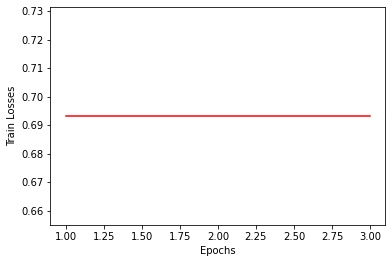

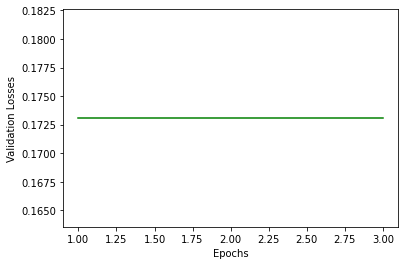

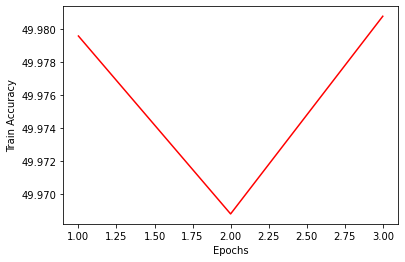

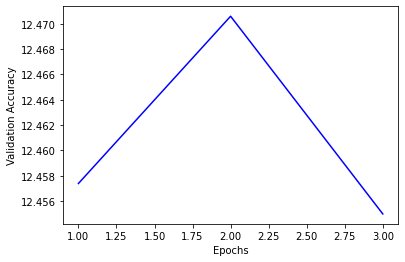

In [18]:
Stats = pd.DataFrame(columns=['Epoch','Train_Loss','Train_Accuracy', 'Validation_Loss','Validation_Accuracy'],data=stats)
plt.plot(Stats['Epoch'], Stats['Train_Loss'],'r')
plt.xlabel('Epochs')
plt.ylabel(f"Train Losses")
plt.show()
plt.plot(Stats['Epoch'], Stats['Validation_Loss'],'g')
plt.xlabel('Epochs')
plt.ylabel(f"Validation Losses")
plt.show()
plt.plot(Stats['Epoch'], Stats['Train_Accuracy'],'r')
plt.xlabel('Epochs')
plt.ylabel(f"Train Accuracy")
plt.show()
plt.plot(Stats['Epoch'], Stats['Validation_Accuracy'],'b')
plt.xlabel('Epochs')
plt.ylabel(f"Validation Accuracy")
plt.show()

## Final Testing with Test Dataset

### Picking 100 random values from Test Dataset

In [47]:
import random
model.eval()
Pred = []
Actl = []

for i in tqdm(range(100)):
    x = random.randint(1,20000)
    with torch.no_grad():
        Pred += torch.round(model(Test[x][0].reshape([1,512]),Test[x][1].reshape([1,512]))).flatten().tolist()
    Actl += Test[x][2].tolist()

100%|██████████| 100/100 [00:31<00:00,  3.19it/s]


In [48]:
def acc(x,y):
    n = 0
    for i in range(len(x)):
        if(x[i]==y[i]):
            n += 1
    return(n/len(x))

print(f"Accuracy of Classification Task {acc(Actl,Pred)*100} %")

Accuracy of Classification Task 51.0 %
